# Title: Cyberbullying Detection and Analysis: NLP Pipeline Report

**Project Objectives and Scope**

The objective of this project was to develop an NLP pipeline for cyberbullying detection and analysis using the chosen dataset from kaggle community. The dataset can be found [here](https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset). The dataset is provided as a `.csv` file with **16309** text posts from Twitter where **32.26% of the tweets were labeled as cyber bullying content**.  The scope of the project included data preprocessing, feature extraction, model training and evaluation, and selecting the best-performing model for cyberbullying detection.

**Data Description**

The dataset used in this project consists of social media text posts labeled as cyberbullying or non-cyberbullying. It contains **16309** instances, with features including **'text','annotation' 'oh_label'**. The 'text' column represents the text content of the social media post, 'annotation' represent the type whether it belongs to category sexist/racism/none and the 'oh_label' column represents the corresponding label (1 for cyberbullying, 0 for non-cyberbullying).

In [2]:
!pip install wordcloud
!pip install imblearn
!pip install --upgrade imbalanced-learn
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
import pickle
import time

In [3]:
df = pd.read_csv('twitter_cleaned.csv')
df.head()

,Text,Annotation,oh_label,pre_processed_text
0,i read them in contextno change in meaning the...,none,0,read contextno chang mean histori islam slaveri
1,now you idiots claim that people who tried to ...,none,0,idiot claim peopl stop terorist made terorist ...
2,cal me sexist but when i go to an auto place i...,sexism,1,cal sexist auto place talk guy
3,wrong isis folows the example of mohamed and t...,racism,1,wrong isi folow moham quran
4,no no no no no no,none,0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Text                16012 non-null  object
 1   Annotation          16309 non-null  object
 2   oh_label            16309 non-null  int64 
 3   pre_processed_text  15762 non-null  object
dtypes: int64(1), object(3)
memory usage: 509.8+ KB


In [5]:
df.isnull().sum()

Text                  297
Annotation              0
oh_label                0
pre_processed_text    547
dtype: int64

In [6]:
df.shape

(16309, 4)

In [7]:
df['Annotation'].unique()

array(['none', 'sexism', 'racism'], dtype=object)

In [8]:
df['oh_label'].unique()

array([0, 1], dtype=int64)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Text                16012 non-null  object
 1   Annotation          16309 non-null  object
 2   oh_label            16309 non-null  int64 
 3   pre_processed_text  15762 non-null  object
dtypes: int64(1), object(3)
memory usage: 509.8+ KB


### Checking Class Imbalance of Original Data's Labels

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Class')

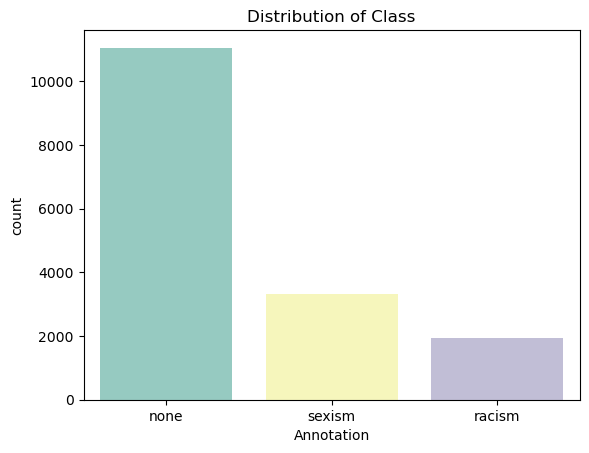

In [10]:
sns.countplot(df['Annotation'], palette='Set3').set_title('Distribution of Class')

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Class')

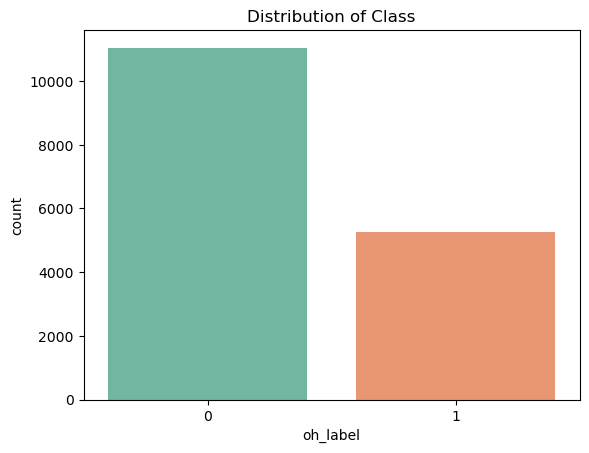

In [11]:
sns.countplot(df['oh_label'], palette='Set2').set_title('Distribution of Class')

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


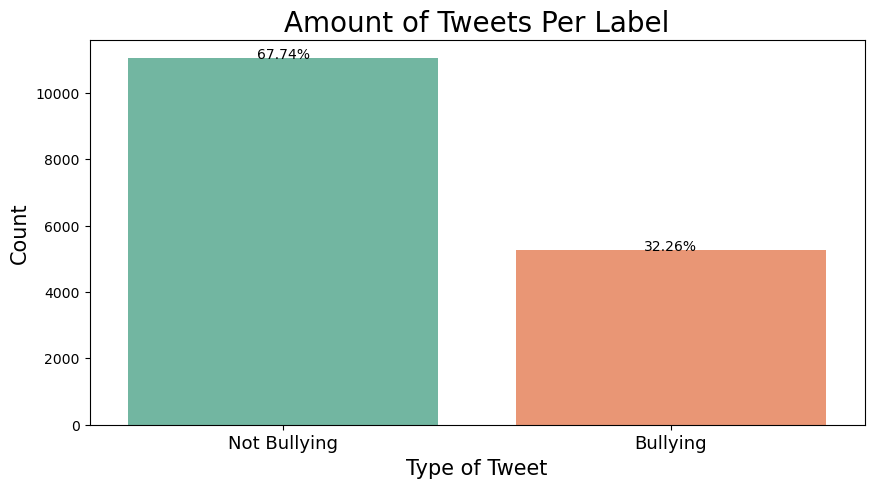

In [12]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['oh_label'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Bullying','Bullying'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

In [13]:
df['oh_label'].sum() / len(df['oh_label'])

0.32258262309154456

### 32% of data is actual bullying 

In [14]:
clean_df = df.copy()

In [15]:
clean_df.head()

,Text,Annotation,oh_label,pre_processed_text
0,i read them in contextno change in meaning the...,none,0,read contextno chang mean histori islam slaveri
1,now you idiots claim that people who tried to ...,none,0,idiot claim peopl stop terorist made terorist ...
2,cal me sexist but when i go to an auto place i...,sexism,1,cal sexist auto place talk guy
3,wrong isis folows the example of mohamed and t...,racism,1,wrong isi folow moham quran
4,no no no no no no,none,0,NaN


In [16]:
clean_df.isnull().sum()

Text                  297
Annotation              0
oh_label                0
pre_processed_text    547
dtype: int64

In [17]:
clean_df = clean_df.dropna(subset=['pre_processed_text','Text'])

In [18]:
clean_df.isnull().sum()

Text                  0
Annotation            0
oh_label              0
pre_processed_text    0
dtype: int64

In [19]:
clean_df.shape

(15762, 4)

In [20]:
clean_df['clean_tweets'] = clean_df['pre_processed_text']
clean_df

,Text,Annotation,oh_label,pre_processed_text,clean_tweets
0,i read them in contextno change in meaning the...,none,0,read contextno chang mean histori islam slaveri,read contextno chang mean histori islam slaveri
1,now you idiots claim that people who tried to ...,none,0,idiot claim peopl stop terorist made terorist ...,idiot claim peopl stop terorist made terorist ...
2,cal me sexist but when i go to an auto place i...,sexism,1,cal sexist auto place talk guy,cal sexist auto place talk guy
3,wrong isis folows the example of mohamed and t...,racism,1,wrong isi folow moham quran,wrong isi folow moham quran
5,saudi preacher who raped and tortured his five...,none,0,saudi preacher rape tortur yearold daughter de...,saudi preacher rape tortur yearold daughter de...
...,...,...,...,...,...
16304,feling so sory for the girls they should be sa...,none,0,fele sori girl safe kat andr home,fele sori girl safe kat andr home
16305,prety god dishes we are hapy with ok wel never...,none,0,preti god dish hapi wel eat place,preti god dish hapi wel eat place
16306,deconstructed lemon tartcan we please go just ...,none,0,deconstruct lemon tartcan season cale deconstruct,deconstruct lemon tartcan season cale deconstruct
16307,you are to stupid to talk to blocked,none,0,stupid talk block,stupid talk block


In [21]:
clean_df = clean_df.drop(["pre_processed_text", "Text"], axis = 1)

In [22]:
clean_df

,Annotation,oh_label,clean_tweets
0,none,0,read contextno chang mean histori islam slaveri
1,none,0,idiot claim peopl stop terorist made terorist ...
2,sexism,1,cal sexist auto place talk guy
3,racism,1,wrong isi folow moham quran
5,none,0,saudi preacher rape tortur yearold daughter de...
...,...,...,...
16304,none,0,fele sori girl safe kat andr home
16305,none,0,preti god dish hapi wel eat place
16306,none,0,deconstruct lemon tartcan season cale deconstruct
16307,none,0,stupid talk block


In [23]:
tweet_df = clean_df[['clean_tweets', 'oh_label']].copy()

In [24]:
tweet_df.head()

,clean_tweets,oh_label
0,read contextno chang mean histori islam slaveri,0
1,idiot claim peopl stop terorist made terorist ...,0
2,cal sexist auto place talk guy,1
3,wrong isi folow moham quran,1
5,saudi preacher rape tortur yearold daughter de...,0


In [25]:
tweet_df.shape

(15762, 2)

In [26]:
data = tweet_df['clean_tweets']
target = tweet_df['oh_label']

### Tokenizing Before Removing Stop Words

In [27]:
# function to tokenize without removing stop words
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collocations import *
def unfiltered_tokens(text):
    dirty_tokens = nltk.word_tokenize(text)
    return dirty_tokens

In [28]:
# applying this function to the `clean_tweets` column
unfilterd_data = list(map(unfiltered_tokens, data))

In [29]:
# morphing `unfiltered_data` into a readable list
flat_unfiltered = [item for sublist in unfilterd_data for item in sublist]

In [30]:
# getting frequency distribution
dirty_corpus_freqdist = FreqDist(flat_unfiltered)
# top 20 words in the corpus
dirty_corpus_freqdist.most_common(20)

[('sexist', 1059),
 ('women', 950),
 ('al', 950),
 ('kat', 946),
 ('wil', 837),
 ('islam', 822),
 ('muslim', 750),
 ('peopl', 678),
 ('girl', 570),
 ('make', 550),
 ('god', 525),
 ('time', 461),
 ('andr', 428),
 ('fuck', 423),
 ('se', 398),
 ('reali', 386),
 ('men', 375),
 ('thing', 359),
 ('isi', 349),
 ('lok', 348)]

### Removing Stop Words in Tokenization

In [31]:
stop_words = set(stopwords.words('english'))

In [32]:
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [33]:
# applying the above function to our data/features 
processed_data = list(map(process_tweet, data))

In [34]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

10530

Here we can see that our corpus has a vocabulary of 16212. This would also be the number of columns in the sparse matrix after we vectorize the data later.

Now that the stop words are removed and the corpus is tokenized, let's take a look at the top words in this corpus

In [35]:
# morphing `processed_data` into a readable list
flat_filtered = [item for sublist in processed_data for item in sublist]
# getting frequency distribution
clean_corpus_freqdist = FreqDist(flat_filtered)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('sexist', 1059),
 ('women', 950),
 ('al', 950),
 ('kat', 946),
 ('wil', 837),
 ('islam', 822),
 ('muslim', 750),
 ('peopl', 678),
 ('girl', 570),
 ('make', 550),
 ('god', 525),
 ('time', 461),
 ('andr', 428),
 ('fuck', 423),
 ('se', 398),
 ('reali', 386),
 ('men', 375),
 ('thing', 359),
 ('isi', 349),
 ('lok', 348)]

We can see that the "meaningless" stop words have been removed from the corpus. Some of the words here are still up for debate, but let's run this data through some baseline models and see how they perform.

In [36]:
# creating a list with all lemmatized outputs
import nltk
from sklearn.feature_extraction import text 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collocations import *
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [161]:
X_lem = lemmatized_output
y_lem = target

### Additional Corpus EDA - Creating Bigrams

In [38]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [39]:

# creating a finder & passing in tokenized corpus
bigram_finder = BigramCollocationFinder.from_words(flat_filtered)

In [40]:

# computing bigram scores
corpus_scored = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [41]:
# top 20 bigrams
corpus_scored[:20]

[(('kat', 'andr'), 0.0038524925731921104),
 (('cal', 'sexist'), 0.0019314949140799681),
 (('sexist', 'women'), 0.0012491733411712836),
 (('instant', 'restaur'), 0.0011127090265895469),
 (('declar', 'war'), 0.0006508298080052066),
 (('kati', 'niki'), 0.0006508298080052066),
 (('quran', 'hadith'), 0.0006508298080052066),
 (('prophet', 'moham'), 0.0006403325530373807),
 (('sexist', 'girl'), 0.0006298352980695549),
 (('suden', 'death'), 0.0005773490232304253),
 (('sexist', 'femal'), 0.0005563545132947734),
 (('year', 'ago'), 0.0005038682384556439),
 (('lemon', 'tart'), 0.0004933709834878179),
 (('ani', 'lloyd'), 0.0004723764735521661),
 (('war', 'al'), 0.00040939294374521063),
 (('restaur', 'round'), 0.0003988956887773847),
 (('al', 'human'), 0.000367403923873907),
 (('promo', 'girl'), 0.000367403923873907),
 (('kat', 'andamp'), 0.00034640941393825514),
 (('hate', 'kat'), 0.0003359121589704292)]

### Calculating Mutual Information Scores

Pointwise Mutual Information Score is a statistical measure from information theory that generally measures the mutual dependence between two words. In plain english, this measures how much information the bigram itself contains by computing the dependence between the two words in the bigram.

In [42]:
# creating a finder for pmi & passing in torkenized corpus
pmi_finder = BigramCollocationFinder.from_words(flat_filtered)

In [43]:
# applying frequency filter that only examines bigrams that occur more than 5 times
pmi_finder.apply_freq_filter(5)

In [44]:
# using finder to calculate pmi scores
pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)

In [45]:
# first 30 elements in this list
pmi_scored[:30]

[(('boko', 'haram'), 13.954665861258679),
 (('alahu', 'akbar'), 13.732273439922235),
 (('fairi', 'tale'), 13.732273439922235),
 (('te', 'ching'), 13.732273439922231),
 (('silicon', 'valey'), 13.539628361979837),
 (('net', 'neutral'), 13.054201534809595),
 (('nobel', 'prize'), 13.054201534809595),
 (('masha', 'gesen'), 12.95466586125868),
 (('leonard', 'nimoy'), 12.732273439922235),
 (('ethnic', 'cleans'), 12.732273439922231),
 (('pact', 'umar'), 12.665159244063698),
 (('tal', 'abyad'), 12.539628361979837),
 (('star', 'trek'), 12.4521655207295),
 (('tao', 'te'), 12.353761816668502),
 (('cou', 'cou'), 12.217700267092475),
 (('chlorin', 'ga'), 12.124590862700995),
 (('tal', 'afar'), 12.054201534809595),
 (('caravan', 'rober'), 12.037128021450654),
 (('politicali', 'corect'), 11.966738693559254),
 (('na', 'na'), 11.950663930701186),
 (('arabian', 'peninsula'), 11.928193649897489),
 (('shave', 'novemb'), 11.869776963672166),
 (('sogi', 'bread'), 11.802662767813633),
 (('polit', 'corectn'), 

These are the top 30 bigrams, according to PMI score. Most of these are identifiable as English slang terms. Def Loaf is an american rapper, and Shylock is a malware that targets banks.

We can impliment bigrams into models using ngram_range during the TF-IDF vectorization stage. From there, we can start running some baseline models to see how they perform with this data.

In [46]:
bigrams_list = pmi_scored[:30]

In [47]:
bigrams_list

[(('boko', 'haram'), 13.954665861258679),
 (('alahu', 'akbar'), 13.732273439922235),
 (('fairi', 'tale'), 13.732273439922235),
 (('te', 'ching'), 13.732273439922231),
 (('silicon', 'valey'), 13.539628361979837),
 (('net', 'neutral'), 13.054201534809595),
 (('nobel', 'prize'), 13.054201534809595),
 (('masha', 'gesen'), 12.95466586125868),
 (('leonard', 'nimoy'), 12.732273439922235),
 (('ethnic', 'cleans'), 12.732273439922231),
 (('pact', 'umar'), 12.665159244063698),
 (('tal', 'abyad'), 12.539628361979837),
 (('star', 'trek'), 12.4521655207295),
 (('tao', 'te'), 12.353761816668502),
 (('cou', 'cou'), 12.217700267092475),
 (('chlorin', 'ga'), 12.124590862700995),
 (('tal', 'afar'), 12.054201534809595),
 (('caravan', 'rober'), 12.037128021450654),
 (('politicali', 'corect'), 11.966738693559254),
 (('na', 'na'), 11.950663930701186),
 (('arabian', 'peninsula'), 11.928193649897489),
 (('shave', 'novemb'), 11.869776963672166),
 (('sogi', 'bread'), 11.802662767813633),
 (('polit', 'corectn'), 

### Visualizing Bigram Frequency

In [48]:
bigrams_series = (pd.Series(nltk.ngrams(flat_filtered, 2)).value_counts())[:20]

Text(0.5, 0, 'Number of Occurances')

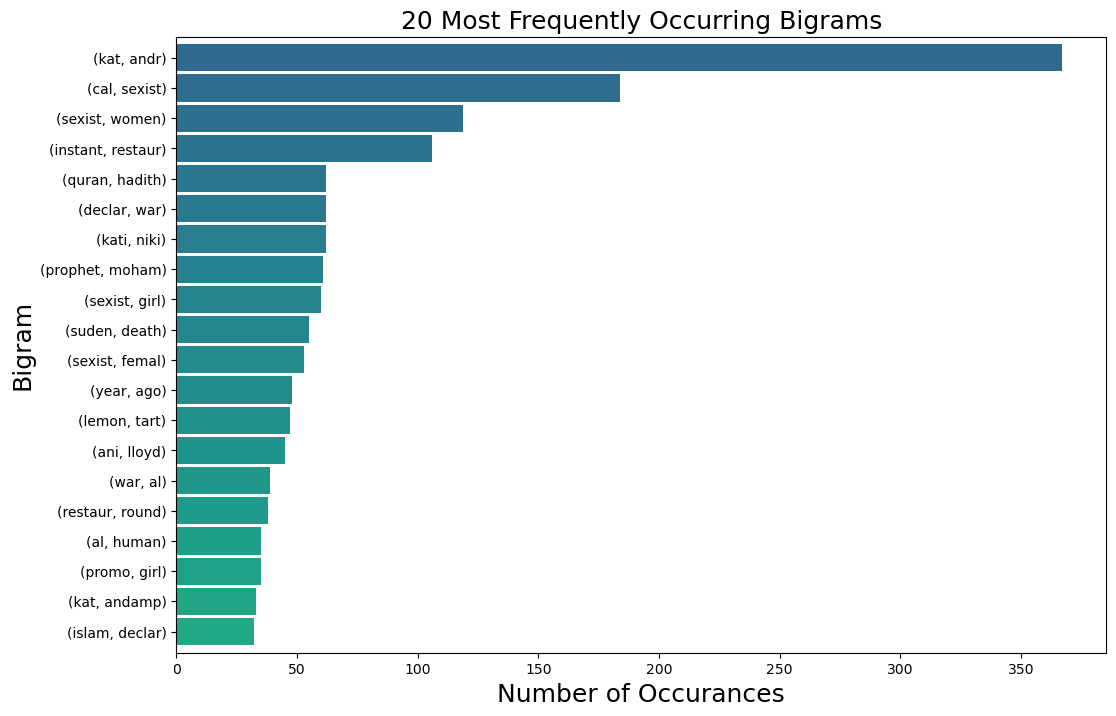

In [49]:
import matplotlib.pyplot as plt
from matplotlib import cm
bigrams_series.sort_values().plot.barh(color=cm.viridis_r(np.linspace(.4,.8, 30)), width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occurring Bigrams', fontsize=18)
plt.ylabel('Bigram', fontsize=18)
plt.xlabel('Number of Occurances', fontsize=18)

### Most Frequent Words for Each Classification

In [50]:
# creating new dfs for each classification
df_freq_bullying = tweet_df[tweet_df['oh_label']==1]
df_freq_not_bullying = tweet_df[tweet_df['oh_label']==0]

In [51]:
# pulling out the text data for cleaned tweets
data_bullying = df_freq_bullying['clean_tweets']
data_not_bullying = df_freq_not_bullying['clean_tweets']

In [52]:
# function to tokenize tweets and remove stop words with NLTK built-in library
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [53]:
# creating lists for processed bullying & not bullying data
process_bullying = list(map(process_tweet, data_bullying))
process_not_bullying = list(map(process_tweet, data_not_bullying))

In [54]:
# exact number in vocab formed from corpus for bullying data 
total_vocab_bullying = set()
for comment in process_bullying:
    total_vocab_bullying.update(comment)
len(total_vocab_bullying)

5609

In [55]:
# exact number in vocab formed from corpus for not bullying data 
total_vocab_NOT_bullying = set()
for comment in process_not_bullying:
    total_vocab_NOT_bullying.update(comment)
len(total_vocab_NOT_bullying)

8488

### Most Common Words in Each Category

In [56]:
flat_bullying = [item for sublist in process_bullying for item in sublist]
flat_not_bullying = [item for sublist in process_not_bullying for item in sublist]

In [57]:
bullying_freq = FreqDist(flat_bullying)
not_bullying_freq = FreqDist(flat_not_bullying)

In [58]:
# Top 20 Bullying Speech words:
bullying_freq.most_common(20)

[('sexist', 966),
 ('women', 617),
 ('muslim', 588),
 ('islam', 576),
 ('girl', 399),
 ('al', 380),
 ('kat', 342),
 ('wil', 250),
 ('femal', 244),
 ('men', 241),
 ('cal', 221),
 ('murder', 219),
 ('peopl', 208),
 ('moham', 205),
 ('make', 191),
 ('woman', 182),
 ('god', 176),
 ('hate', 175),
 ('religion', 151),
 ('year', 145)]

In [59]:
not_bullying_freq.most_common(20)

[('kat', 604),
 ('wil', 587),
 ('al', 570),
 ('peopl', 470),
 ('andr', 376),
 ('make', 359),
 ('god', 349),
 ('time', 337),
 ('women', 333),
 ('fuck', 295),
 ('se', 278),
 ('reali', 268),
 ('thing', 259),
 ('islam', 246),
 ('lok', 239),
 ('ben', 229),
 ('ned', 224),
 ('isi', 213),
 ('talk', 200),
 ('love', 194)]

### Normalizing Word Frequencies

In [60]:
bullying_total_word_count = sum(bullying_freq.values())
bullying_top_25 = bullying_freq.most_common(25)
print("Bullying Word \t Normalized Frequency")
print()
for word in bullying_top_25:
    normalized_frequency = word[1]/bullying_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Bullying Word 	 Normalized Frequency

sexist 		 0.02771
women 		 0.0177
muslim 		 0.01686
islam 		 0.01652
girl 		 0.01144
al 		 0.0109
kat 		 0.009809
wil 		 0.00717
femal 		 0.006998
men 		 0.006912
cal 		 0.006338
murder 		 0.006281
peopl 		 0.005966
moham 		 0.005879
make 		 0.005478
woman 		 0.00522
god 		 0.005048
hate 		 0.005019
religion 		 0.004331
year 		 0.004159
isi 		 0.003901
prophet 		 0.003901
quran 		 0.003843
jew 		 0.003843
feminist 		 0.003728


In [61]:
not_bullying_total_word_count = sum(not_bullying_freq.values())
not_bullying_top_25 = not_bullying_freq.most_common(25)
print("Not Bullying Word \t Normalized Frequency")
print()
for word in not_bullying_top_25:
    normalized_frequency = word[1]/not_bullying_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Not Bullying Word 	 Normalized Frequency

kat 		 0.01
wil 		 0.009719
al 		 0.009438
peopl 		 0.007782
andr 		 0.006226
make 		 0.005944
god 		 0.005779
time 		 0.00558
women 		 0.005514
fuck 		 0.004884
se 		 0.004603
reali 		 0.004437
thing 		 0.004288
islam 		 0.004073
lok 		 0.003957
ben 		 0.003792
ned 		 0.003709
isi 		 0.003527
talk 		 0.003311
love 		 0.003212
wel 		 0.003212
show 		 0.003146
andamp 		 0.003113
back 		 0.002947
stil 		 0.002881


### Visualizing Top Word Percentages

In [62]:
# create counts of bullying and not bullying with values and words
bullying_bar_counts = [x[1] for x in bullying_freq.most_common(20)]
bullying_bar_words = [x[0] for x in bullying_freq.most_common(20)]

not_bullying_bar_counts = [x[1] for x in not_bullying_freq.most_common(20)]
not_bullying_bar_words = [x[0] for x in not_bullying_freq.most_common(20)]

In [63]:
# set the color of the bar graphs
color = cm.magma(np.linspace(.4,.8, 30))

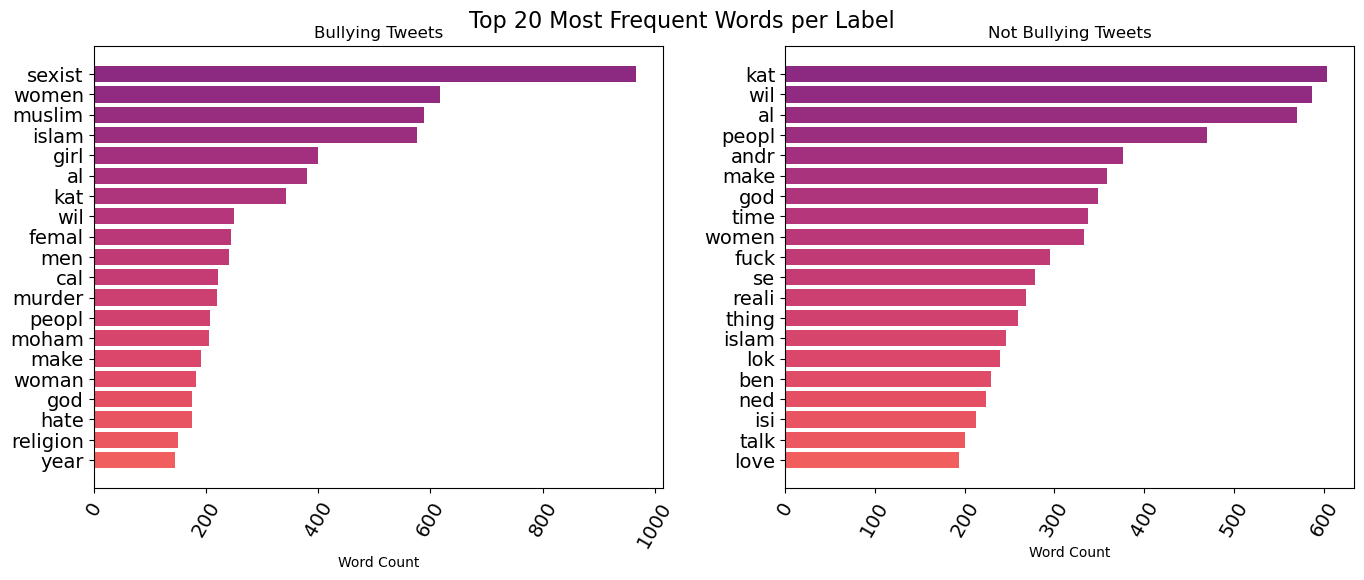

In [64]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# generating a bar chart on each axes
ax.barh(bullying_bar_words, bullying_bar_counts, color=color)
ax2.barh(not_bullying_bar_words, not_bullying_bar_counts, color=color)

ax.title.set_text('Bullying Tweets')
ax2.title.set_text('Not Bullying Tweets')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)
plt.show()

### What Words are Only in Bullying Tweets?

In [65]:
def returnNotMatches(a, b):
    return [x for x in a if x not in b]

In [66]:
returnNotMatches(flat_bullying, flat_not_bullying)

['roney',
 'striker',
 'geordi',
 'shore',
 'bute',
 'idiosyncrasi',
 'funili',
 'iner',
 'bogun',
 'geographi',
 'butno',
 'comedien',
 'rli',
 'unfuni',
 'guesit',
 'rig',
 'av',
 'yesand',
 'fanat',
 'jenif',
 'lopez',
 'iliad',
 'stupidist',
 'patriot',
 'wean',
 'ture',
 'foke',
 'revis',
 'thot',
 'femshep',
 'apeas',
 'iowa',
 'barf',
 'erect',
 'raper',
 'wnba',
 'parenthod',
 'thatyou',
 'katjia',
 'uteru',
 'abnorm',
 'enrich',
 'wisdom',
 'walkyou',
 'girlon',
 'rap',
 'supermodel',
 'insecur',
 'hockey',
 'excitin',
 'apathi',
 'mistakenli',
 'conflat',
 'cuntyou',
 'diseas',
 'perish',
 'thatfemin',
 'argmnt',
 'oversalt',
 'cucumb',
 'unprotect',
 'ere',
 'jobotherwis',
 'sportsperso',
 'imperialist',
 'imperialist',
 'coburn',
 'hawk',
 'mistaketok',
 'timonen',
 'hextal',
 'seriouslyw',
 'fakedumb',
 'holypleas',
 'holer',
 'whilst',
 'babe',
 'anoyi',
 'thigh',
 'molest',
 'noit',
 'influenti',
 'wom',
 'scot',
 'walker',
 'menwomen',
 'apologist',
 'belaru',
 'superio

### Visualizing Unique Words with Venn Diagram

In [67]:
!pip install matplotlib_venn
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Comparison of Unique Words in Each Corpus Label')

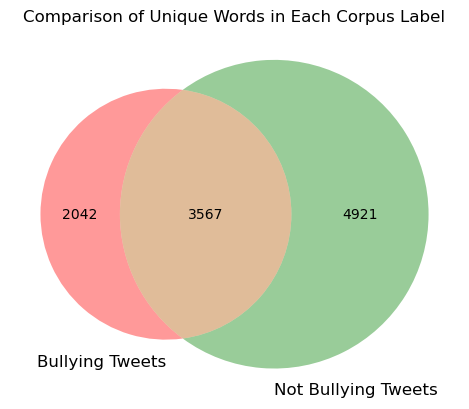

In [68]:
venn2([set(flat_bullying), set(flat_not_bullying)], set_labels = ('Bullying Tweets', 'Not Bullying Tweets'))
plt.title('Comparison of Unique Words in Each Corpus Label')

### Word Clouds

In [69]:
from wordcloud import WordCloud
bullying_dict = dict(zip(bullying_bar_words, bullying_bar_counts))
not_bullying_dict = dict(zip(not_bullying_bar_words, not_bullying_bar_counts))

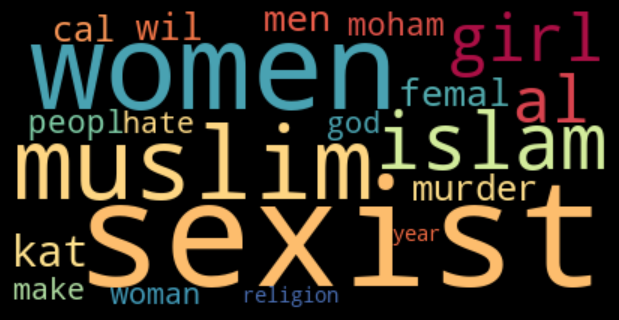

In [70]:
# create the word cloud:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(bullying_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

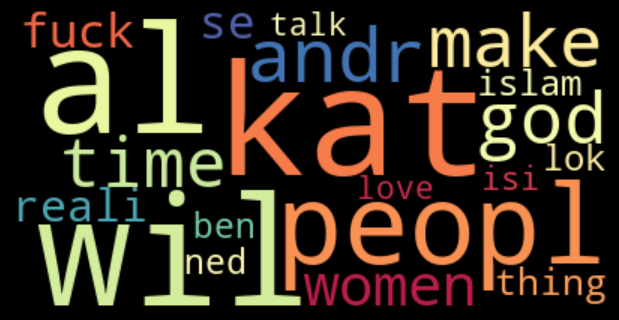

In [71]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_bullying_dict)

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

These word clouds are pretty much unusable on public-facing documents, but they tell us that the top words for each label are very similar. It may be hard for the models to differentiate beteween what can be classified as bullying or not

### Tweet Cloud of Most Frequent Words in Corpus

In [72]:
tweet_df = clean_df[['clean_tweets', 'oh_label']].copy()

In [73]:
tweet_df.to_csv('corpus.txt', sep='|')

In [74]:
!pip install stylecloud
import stylecloud
stylecloud.gen_stylecloud(file_path='corpus.txt', icon_name='fab fa-twitter')

### EDA on Annotation Column
We can see majority belongs to none ,but few percentage adds to racism and sexist categories which we are mainly intested in.

<AxesSubplot:>

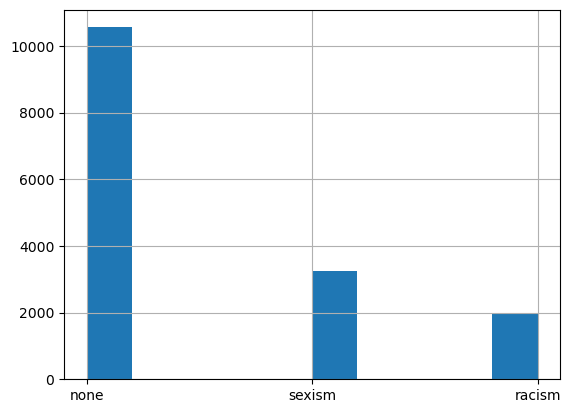

In [75]:
clean_df.Annotation.hist()

## Splitting the data into Train - Test 

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

In [77]:
# instantiating tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [78]:
# transforming tokenized data into sparse matrix format with 20K stored elements
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [79]:
# taking a quick look at the non zero elements
non_zero_cols = X_train_tfidf.nnz / float(X_train_tfidf.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))
percent_sparse = 1 - (non_zero_cols / float(X_train_tfidf.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 10.900626536600841
Percentage of columns containing ZERO: 0.9998205983025855


In [80]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

In [81]:
%%time
rf_baseline.fit(X_train_tfidf, y_train)
rf_test_preds = rf_baseline.predict(X_test_tfidf)

Wall time: 51.1 s


In [82]:
# custom fuctions
import helper_functions as helpers
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
helpers.evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.7725
Recall: 0.6065
F1 Score: 0.6795
Weighted F1 Score: 0.8034


In [83]:
%%time
# training f1
from sklearn.model_selection import cross_val_score, GridSearchCV
rf_f1_cv = cross_val_score(rf_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
rf_mean_cv = round(rf_f1_cv.mean(), 6)

Wall time: 10min 24s


In [84]:
# Checking if the model is overfit or underfit?
rf_fit = helpers.model_fit(rf_mean_cv, rf_f1_score)
rf_fit


'underfit'

### Overfit vs. Underfit

Above, I used a custom function to streamline the categorization process. For instance, when a model's training metrics are higher than its testing metrics, then it is overfit.

Generally, a slightly underfit model is preferred. This means that the model is not too specific to the training data, and it should be able to generalize well on unseen data.

We can continue to run this custom fuction on future iterations to determine each model's fit. We can also store all the testing set evaluation metrics for each model into a dictionary, and display them in a dataframe later for comparison.

In [85]:
# creating dictionary to store all metrics
metric_dict = {}
# adding scores to metric_dict
metric_dict['Baseline Random Forest - TFIDF'] = {'precision': rf_precision, 'recall': rf_recall, 'f1_score': rf_f1_score, 'weighted_f1': rf_f1_weighted, 'fit': rf_fit}

### Baseline Logistic Regression
Logistic Regression is another common model used for classification tasks. Additionally, this model tends to work better with larger datasets.

In [86]:
log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

Here I added class_weight='balanced' again, but this actually didn't impact the score. So we'll keep that hyperparamter. Also note that the penality is set to L2, but that's already the default.

In [87]:
%%time
log_reg_baseline.fit(X_train_tfidf, y_train)
log_reg_test_preds = log_reg_baseline.predict(X_test_tfidf)

Wall time: 564 ms


In [88]:
log_reg_precision = precision_score(y_test, log_reg_test_preds)
log_reg_recall = recall_score(y_test, log_reg_test_preds)
log_reg_f1_score = f1_score(y_test, log_reg_test_preds)
log_reg_f1_weighted = f1_score(y_test, log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(log_reg_precision, log_reg_recall, log_reg_f1_score, log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.6971
Recall: 0.7297
F1 Score: 0.713
Weighted F1 Score: 0.806


Compared the the first Random Forest baseline, the Logistic Regression baseline performed much better. The F1 score increased from 0.679 to 0.713.

Although, this F1 score could still be increased. Before deciding on the model to iterate on, let's try Naive Bayes and SVM baselines first.

In [89]:
%%time
# training f1
log_reg_f1_cv = cross_val_score(log_reg_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
log_reg_mean_cv = round(log_reg_f1_cv.mean(), 6)

Wall time: 2.92 s


In [90]:
# Let us check if is this model overfit or underfit?
log_reg_fit = helpers.model_fit(log_reg_mean_cv, log_reg_f1_score)
log_reg_fit

'underfit'

In [91]:
# adding scores to metric_dict
metric_dict['Baseline Log Reg - TFIDF'] = {'precision': log_reg_precision, 'recall': log_reg_recall, 'f1_score': log_reg_f1_score, 'weighted_f1': log_reg_f1_weighted, 'fit': log_reg_fit}

### Baseline Naive Bayes

In [92]:
from sklearn.naive_bayes import MultinomialNB
baseline_bayes = MultinomialNB(alpha = .01)

In [93]:
%%time
baseline_bayes.fit(X_train_tfidf, y_train)
bayes_test_preds = baseline_bayes.predict(X_test_tfidf)

Wall time: 15.6 ms


In [94]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
helpers.evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.6872
Recall: 0.6189
F1 Score: 0.6513
Weighted F1 Score: 0.7768


The F1 score dropped down to 0.6513. So, this model performed worse than both the Random Forest and Logistic Regression models. This is surprising because Naive Bayes typically performs pretty well with text data. This could indicate that preprocessing steps could be improved.

For now, let's try the last baseline and decide which model to iterate on.

In [95]:
%%time
# training f1
bayes_f1_cv = cross_val_score(baseline_bayes, X_train_tfidf, y_train, scoring='f1', cv=5)
bayes_mean_cv = round(bayes_f1_cv.mean(), 6)

Wall time: 56.1 ms


In [96]:
# Checking if the model is overfit or underfit?
bayes_fit = helpers.model_fit(bayes_mean_cv, bayes_f1_score)
bayes_fit

'overfit'

In [97]:
# adding scores to metric_dict
metric_dict['Baseline Naive Bayes - TFIDF'] = {'precision': bayes_precision, 'recall': bayes_recall, 'f1_score': bayes_f1_score, 'weighted_f1': bayes_f1_weighted, 'fit': bayes_fit}

### Baseline Support Vector Machine (SVM)

An SVM is a type of classifier that modifies the loss function for optimization to not only take into account overall accuracy metrics of the resulting predictions, but also to maximize the decision boundary between the data points. Essentially, this further helps tune the classifier as a good balance between underfitting and overfitting.

A notable hyperparameter is the Kernel, which reprojects data onto a new parameter space using combinations of existing features. From there, the same process of applying SVMs to this transformed space can then be employed. This could provide more complex boundaries than just Linear.

For now, I am trying SVM with a Linear kernel as a baseline.

In [98]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

I have also added class_weight='balanced' to SVM models. This helps to deal with the huge class imbalance in this dataset.

In [99]:
%%time 
# fit the training dataset on the classifier
SVM_baseline.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(X_test_tfidf)

Wall time: 38.3 s


In [100]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.6926
Recall: 0.7488
F1 Score: 0.7196
Weighted F1 Score: 0.808


This model produced the highest F1 so far, with a score of 0.7196. Next, let's look at the performance of all baselines all together, and move forward with a single model to iterate on.

In [101]:
%%time
# training f1
base_SVM_f1_cv = cross_val_score(SVM_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
base_SVM_mean_cv = round(base_SVM_f1_cv.mean(), 6)

Wall time: 1min 29s


In [102]:
# Checking if the model is overfit or underfit?
base_SVM_fit = helpers.model_fit(base_SVM_mean_cv, SVM_f1_score)
base_SVM_fit

'underfit'

In [103]:
# adding scores to metric_dict
metric_dict['Baseline SVM - TFIDF'] = {'precision': SVM_precision, 'recall': SVM_recall, 'f1_score': SVM_f1_score, 'weighted_f1': SVM_f1_weighted, 'fit': base_SVM_fit}

## Evaluation Metrics for All Baseline Models

In [104]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.772506,0.606495,0.679508,0.803404,underfit
Baseline Log Reg - TFIDF,0.697080,0.729704,0.713019,0.806030,underfit
Baseline Naive Bayes - TFIDF,0.687169,0.618911,0.651256,0.776793,overfit
Baseline SVM - TFIDF,0.692580,0.748806,0.719596,0.808000,underfit


It's a pretty close call between the Logistic Regression and SVM baselines. But overall, the **Linear SVM model** performed the best across both uniform and weighted F1. However, there is still work to be done to bring that score up higher.

Next, we'll try improving that model with other feature engineering techniques, class imbalance remedy methods and tuning hyperparameters with grid search.

## Alternative Feature Engineering Methods
In this section, we can experiment with Count Vectorization and Doc2Vec as they are different ways to represent the data in a format that the machine learning models can "understand."

## Doc2Vec

I am trying Doc2Vec feature engineering, which is an extension of Word2Vec. It aims to learn how to project a document into a latent d-dimensional space. Specifically, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output.

In [105]:
# fresh TTS for doc2vec data
doc_train, doc_test = train_test_split(tweet_df, test_size=0.3, random_state=42)

## Data Preparation
After performing a fresh train test split of the original dataframe, the next step is tokenizing the text as usual. Again, we can do this with NLTK.

The lambda functions below will tokenize both the training and test set and tag each tweet with its label, "Bullying" or "Not Bullying."

In [106]:
# tagging training set
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_train = doc_train.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.oh_label]), axis=1)
# tagging testing set
tagged_test = doc_test.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.oh_label]), axis=1)

In [107]:
tagged_train.values[30]

TaggedDocument(words=['suport', 'ghazi', 'safe', 'vent', 'space', 'peopl', 'victim', 'gamerg', 'haras'], tags=[0])

### Training DBOW Model

As mentioned before, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output. It's similar to the Skip-gram model in Word2Vec.

The hyperparameters I am using are as follows:
- `vector_size`: dimensionality of the feature vectors
- `alpha`: initial learning rate
- `min_count`: ignores all words with total frequency lower than this
- `dm`: defines the training algorithm; when dm=1, 'distributed memeory' (PV-DVM) is used
- `epochs`: number of iterations (epochs) over the corpus, defaults to 10 for Doc2Vec

In [108]:
# instantiating a doc2vec DBOW model
dbow_model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1,epochs =100)

In [109]:
from tqdm import tqdm
from sklearn import utils
tqdm.pandas(desc="progress-bar")

# building vocabulary 
dbow_model.build_vocab([x for x in tqdm(tagged_train.values)])

100%|██████████| 11033/11033 [00:00<00:00, 1107234.44it/s]


In [110]:

%%time
for epoch in range(30):
    dbow_model.train(utils.shuffle([x for x in tqdm(tagged_train.values)]), total_examples=len(tagged_train.values), epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 11033/11033 [00:00<00:00, 581302.60it/s]


Wall time: 25.6 s


## Applying Doc2Vec Data to Train Baseline Linear SVM

The custom function `vec_for_learning` simply transforms the tagged tweets into vectors that are suitable for classification model use.

In [111]:
def vec_for_learning(model, tagged_docs):
    """Final vector feature for classifier use"""
    targets = []
    regressors = []
    for doc in tagged_docs:
        vector = model.infer_vector(doc.words)
        targets.append(doc.tags[0])
        regressors.append(vector)
    return targets, regressors


In [112]:
# train-test split
doc_y_train, doc_X_train = vec_for_learning(dbow_model, tagged_train)
doc_y_test, doc_X_test = vec_for_learning(dbow_model, tagged_test)

In [113]:
# instantiating new SVM model
Doc2Vec_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

In [114]:
%%time
# fit the training dataset on the classifier
Doc2Vec_SVM.fit(doc_X_train, doc_y_train)

Wall time: 18.4 s


SVC(class_weight='balanced', gamma='auto', kernel='linear')

In [115]:
doc_SVM_y_preds = Doc2Vec_SVM.predict(doc_X_test)

In [116]:
doc_SVM_precision = precision_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_recall = recall_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_score = f1_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_weighted = f1_score(doc_y_test, doc_SVM_y_preds, average='weighted')

# printing scores
helpers.evaluation(doc_SVM_precision, doc_SVM_recall, doc_SVM_f1_score, doc_SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.468
Recall: 0.4182
F1 Score: 0.4417
Weighted F1 Score: 0.6354


In [117]:
%%time
# training f1
doc_SVM_f1_cv = cross_val_score(Doc2Vec_SVM, doc_X_train, doc_y_train, scoring='f1', cv=5)
doc_SVM_mean_cv = round(doc_SVM_f1_cv.mean(), 6)

Wall time: 1min 6s


In [118]:
# Checking if the model is overfit or underfit?
doc_SVM_fit = helpers.model_fit(doc_SVM_mean_cv, doc_SVM_f1_score)
doc_SVM_fit

'underfit'

In [119]:
metric_dict['Baseline SVM - Doc2Vec'] = {'precision': doc_SVM_precision, 'recall': doc_SVM_recall, 'f1_score': doc_SVM_f1_score, 'weighted_f1': doc_SVM_f1_weighted, 'fit': doc_SVM_fit}

### Comparing with Other Models

In [120]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.772506,0.606495,0.679508,0.803404,underfit
Baseline Log Reg - TFIDF,0.697080,0.729704,0.713019,0.806030,underfit
Baseline Naive Bayes - TFIDF,0.687169,0.618911,0.651256,0.776793,overfit
Baseline SVM - TFIDF,0.692580,0.748806,0.719596,0.808000,underfit
Baseline SVM - Doc2Vec,0.467967,0.418171,0.441669,0.635421,underfit


### SVM Baselines: TF-IDF vs. Doc2Vec

In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report
target_names = ['class 0', 'class 1']
# Tf-IDF baseline
print('-'*14 + ' SVM Baseline with TF-IDF ' + '-'*13)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Doc2Vec baseline
print('-'*13 + ' SVM Baseline with Doc2Vec ' + '-'*13)
print(classification_report(doc_y_test, doc_SVM_y_preds, target_names=target_names))

-------------- SVM Baseline with TF-IDF -------------
              precision    recall  f1-score   support

     class 0       0.87      0.83      0.85      2106
     class 1       0.69      0.75      0.72      1047

    accuracy                           0.81      3153
   macro avg       0.78      0.79      0.79      3153
weighted avg       0.81      0.81      0.81      3153

------------- SVM Baseline with Doc2Vec -------------
              precision    recall  f1-score   support

     class 0       0.72      0.76      0.74      3122
     class 1       0.47      0.42      0.44      1607

    accuracy                           0.64      4729
   macro avg       0.59      0.59      0.59      4729
weighted avg       0.63      0.64      0.64      4729



## Count Vectorization

In [220]:
# fresh TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

In [221]:
# instantiating count vectorizer
count = CountVectorizer(stop_words=stop_words)

In [222]:
# fitting to the train and test set
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

## Baseline Linear SVM with Count Vectorization

With TF-IDF Vectorization, the Linear SVM achieved an F1 of 0.7195. Let's see the Count Vectorization method for feature engineering can improve that score.

In [223]:
count_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

In [224]:
%%time 
# fit the training dataset on the classifier
count_SVM.fit(X_train_count, y_train)
# predict the labels on validation dataset
count_SVM_test_preds = count_SVM.predict(X_test_count)

Wall time: 25.8 s


In [226]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report
count_SVM_precision = precision_score(y_test, count_SVM_test_preds)
count_SVM_recall = recall_score(y_test, count_SVM_test_preds)
count_SVM_f1_score = f1_score(y_test, count_SVM_test_preds)
count_SVM_f1_weighted = f1_score(y_test, count_SVM_test_preds, average='weighted')

# printing scores
target_names = ['class 0', 'class 1']
print(classification_report(y_test, count_SVM_test_preds, target_names=target_names))
helpers.evaluation(count_SVM_precision, count_SVM_recall, count_SVM_f1_score, count_SVM_f1_weighted)

              precision    recall  f1-score   support

     class 0       0.85      0.84      0.84      2094
     class 1       0.69      0.71      0.70      1059

    accuracy                           0.79      3153
   macro avg       0.77      0.77      0.77      3153
weighted avg       0.80      0.79      0.80      3153

Testing Set Evaluation Metrics:
Precision: 0.689
Recall: 0.7092
F1 Score: 0.6989
Weighted F1 Score: 0.7955


Unfortunately this model did not achieve a higher F1 than the TF-IDF version of the SVM model.  But as mentioned before, a balance between high recall and high F1 is important for this business context.


In [171]:
%%time
# training f1
count_SVM_f1_cv = cross_val_score(count_SVM, doc_X_train, doc_y_train, scoring='f1', cv=5)
count_SVM_mean_cv = round(count_SVM_f1_cv.mean(), 6)

Wall time: 1min 6s


In [172]:
# Checking if this model is overfit or underfit?
count_SVM_fit = helpers.model_fit(doc_SVM_mean_cv, doc_SVM_f1_score)
count_SVM_fit

'underfit'

In [173]:
metric_dict['Baseline SVM - CountVectorizer'] = {'precision': count_SVM_precision, 'recall': count_SVM_recall, 'f1_score': count_SVM_f1_score, 'weighted_f1': count_SVM_f1_weighted, 'fit': count_SVM_fit}

## Baseline Logistic Regression with Count Vectorization

The initial Logistic Regression model using TF-IDF Vectorization achieved a decent F1 score of 0.3878. Additionally, that baseline actually had a higher F1 and recall than this recent Linear SVM with CountVectorization. Let's see if this new feature engineering method has an impact.

In [177]:
# instantiate model
count_log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [178]:
%%time
count_log_reg_baseline.fit(X_train_count, y_train)
count_log_reg_test_preds = count_log_reg_baseline.predict(X_test_count)

Wall time: 296 ms


In [179]:
count_log_reg_precision = precision_score(y_test, count_log_reg_test_preds)
count_log_reg_recall = recall_score(y_test, count_log_reg_test_preds)
count_log_reg_f1_score = f1_score(y_test, count_log_reg_test_preds)
count_log_reg_f1_weighted = f1_score(y_test, count_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(count_log_reg_precision, count_log_reg_recall, count_log_reg_f1_score, count_log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.7252
Recall: 0.7252
F1 Score: 0.7252
Weighted F1 Score: 0.8154


In [180]:
%%time
# training f1
count_log_reg_f1_cv = cross_val_score(count_log_reg_baseline, doc_X_train, doc_y_train, scoring='f1', cv=5)
count_log_reg_mean_cv = round(count_log_reg_f1_cv.mean(), 6)

Wall time: 487 ms


In [181]:
# Checking if this model is overfit or underfit?
count_log_reg_fit = helpers.model_fit(count_log_reg_mean_cv, count_log_reg_f1_score)
count_log_reg_fit

'underfit'

In [182]:
metric_dict['Baseline Log Reg - CountVectorizer'] = {'precision': count_log_reg_precision, 'recall': count_log_reg_recall, 'f1_score': count_log_reg_f1_score, 'weighted_f1': count_log_reg_f1_weighted, 'fit': count_log_reg_fit}

# Dealing with Class Imbalance

The Logistic Regression model dealt with class imbalance with the parameter `class_weight='balanced'`. Let's try other class imbalance remedy methods to improve the baseline, before tuning hyperparameters with grid search.

## Over-Sampling with SMOTE
This method over-samples the minority class, " Identify Bullying ".

Rather than simply oversampling the minority class with replacement (which adds duplicate cases to the dataset), the algorithm generates new sample data by creating ‘synthetic’ examples that are combinations of the closest minority class cases.

After synthetically resampling our data, we no longer need to lean on penalized class weights in order to improve our model tuning.

In [192]:
!pip install --upgrade imbalanced-learn
from imblearn.over_sampling import SMOTE
# generating new sample data from original TF-IDF vectorized data
sm = SMOTE(random_state=40)
smote_X_train, smote_y_train = sm.fit_resample(X_train_count, y_train)

In [193]:
# feeding in best log reg model
smote_log_reg = LogisticRegression(penalty='l2', random_state=55)

In [194]:
%%time
smote_log_reg.fit(smote_X_train, smote_y_train)
smote_log_reg_test_preds = smote_log_reg.predict(X_test_count)

Wall time: 356 ms


In [196]:
smote_precision = precision_score(y_test, smote_log_reg_test_preds)
smote_recall = recall_score(y_test, smote_log_reg_test_preds)
smote_f1_score = f1_score(y_test, smote_log_reg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(smote_precision, smote_recall, smote_f1_score, smote_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.6331
Recall: 0.7252
F1 Score: 0.6761
Weighted F1 Score: 0.77


In [197]:
%%time
# training f1
smote_f1_cv = cross_val_score(smote_log_reg, smote_X_train, smote_y_train, scoring='f1', cv=5)
smote_f1_mean_cv = round(smote_f1_cv.mean(), 6)

Wall time: 2.94 s


In [198]:
# Checking if this model is overfit or underfit?
smote_fit = helpers.model_fit(smote_f1_mean_cv, smote_f1_score)
smote_fit

'overfit'

In [199]:
# adding these metrics to evaluation metric dict
metric_dict['Log Reg Oversampled - CountVectorizer'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score, 'fit': smote_fit}

## Under-Sampling with Tomek Links
This method under-samples the majoirty class, "Not Bullying data."


In [200]:
# resampling original TF-IDF vectorized data
tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(X_train_count, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 8422, 1: 4147})


In [201]:
tomek_log_reg = LogisticRegression(penalty='l2', random_state=55)

In [202]:
%%time
tomek_log_reg.fit(tomek_X_train, tomek_y_train)
tomek_log_reg_test_preds = tomek_log_reg.predict(X_test_count)

Wall time: 807 ms


In [203]:
tomek_precision = precision_score(y_test, tomek_log_reg_test_preds)
tomek_recall = recall_score(y_test, tomek_log_reg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_log_reg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(tomek_precision, tomek_recall, tomek_f1_score, tomek_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.785
Recall: 0.6242
F1 Score: 0.6954
Weighted F1 Score: 0.8104


In [204]:
%%time
# training f1
tomek_f1_cv = cross_val_score(tomek_log_reg, tomek_X_train, tomek_y_train, scoring='f1', cv=5)
tomek_mean_cv = round(tomek_f1_cv.mean(), 6)

Wall time: 1.5 s


In [205]:
# Checking if this model is overfit or underfit?
tomek_fit = helpers.model_fit(tomek_mean_cv, tomek_f1_score)
tomek_fit

'underfit'

In [206]:
# adding these metrics to evaluation metric dict
metric_dict['Log Reg Undersampled - CountVectorizer'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score, 'fit': tomek_fit}

# Evaluating All Models

In [207]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.772506,0.606495,0.679508,0.803404,underfit
Baseline Log Reg - TFIDF,0.697080,0.729704,0.713019,0.806030,underfit
Baseline Naive Bayes - TFIDF,0.687169,0.618911,0.651256,0.776793,overfit
Baseline SVM - TFIDF,0.692580,0.748806,0.719596,0.808000,underfit
Baseline SVM - Doc2Vec,0.467967,0.418171,0.441669,0.635421,underfit
Baseline SVM - CountVectorizer,0.688991,0.709160,0.698930,0.795514,underfit
Baseline Log Reg - CountVectorizer,0.725212,0.725212,0.725212,0.815414,underfit
Log Reg Oversampled - CountVectorizer,0.633141,0.725212,0.676056,0.770027,overfit
Log Reg Undersampled - CountVectorizer,0.785036,0.624174,0.695423,0.810408,underfit


## Evaluation Metrics for Testing Set

These scores give us insights of how the model will perform on unseen data.

In [208]:
helpers.evaluation(count_log_reg_precision, count_log_reg_recall, count_log_reg_f1_score, count_log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.7252
Recall: 0.7252
F1 Score: 0.7252
Weighted F1 Score: 0.8154


In [160]:
# cross validated f1 score for training set
print('Training F1 Score: {:.5}'.format(count_log_reg_mean_cv))
# uniform f1 score for testing set
print('Testing F1 Score: {:.5}'.format(count_log_reg_f1_score))

Training F1 Score: 0.47898
Testing F1 Score: 0.72521


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


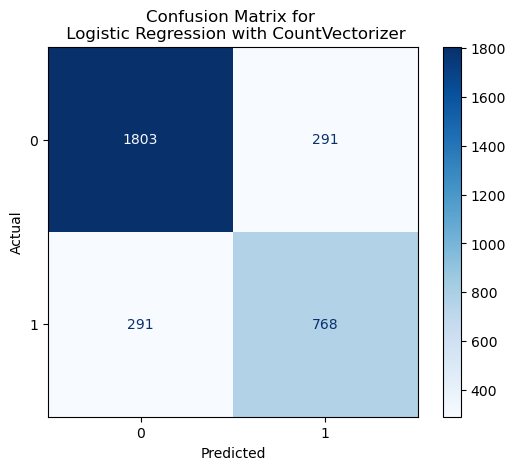

In [210]:
# generating standard confusion matrix for testing set
SVM_conf_matrix = plot_confusion_matrix(count_log_reg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)
SVM_conf_matrix.ax_.set_title('Confusion Matrix for \n Logistic Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


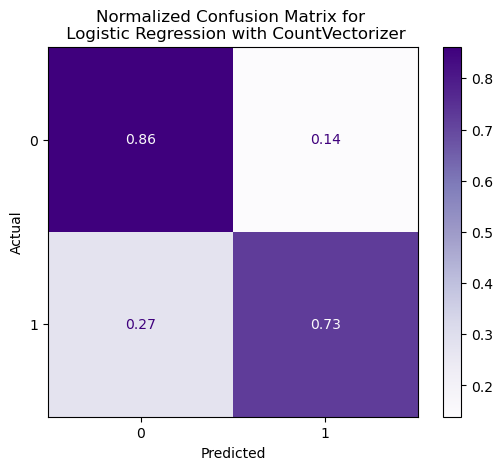

In [211]:
# generating normalized confusion matrix for testing set
SVM_conf_matrix = plot_confusion_matrix(count_log_reg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logistic Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()